In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import constants, iceberg, metocean, drift, tools, simulator, test_case, plot, timesteppers

In [2]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity

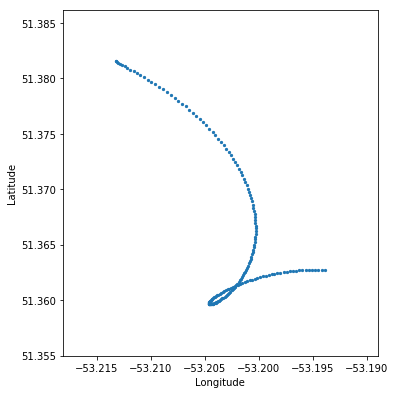

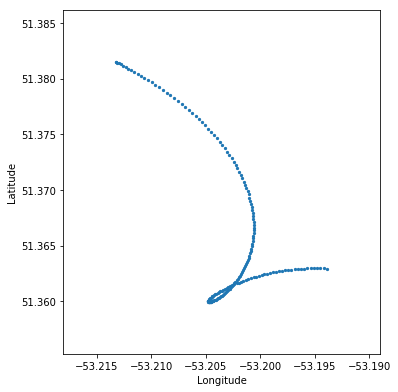

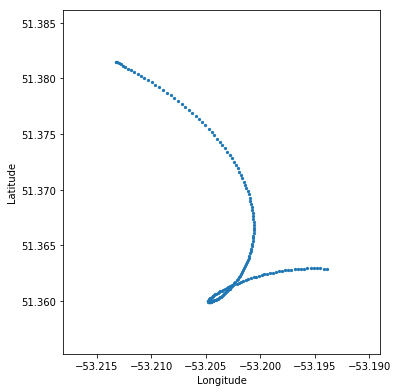

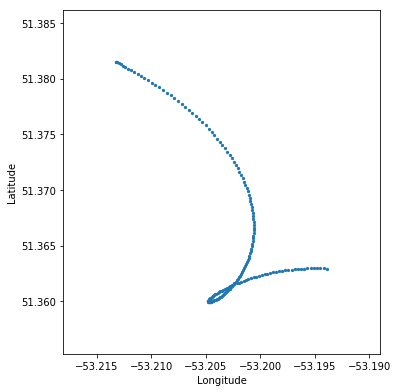

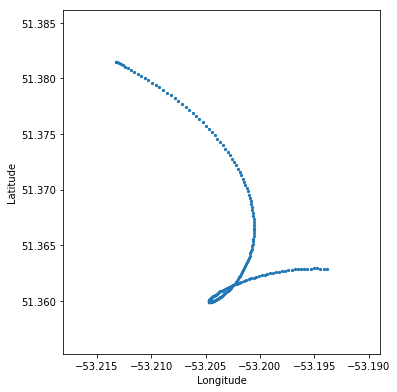

In [3]:
sim = simulator.Simulator()

sim.time_stepper = timesteppers.euler
sim.run_simulation(start_location, time_frame, store_results_as='euler')
plot.plot_iceberg_track(sim.results['euler']['latitude'], sim.results['euler']['longitude'])

sim.time_stepper = timesteppers.rk2
sim.run_simulation(start_location, time_frame, store_results_as='rk2')
plot.plot_iceberg_track(sim.results['rk2']['latitude'], sim.results['rk2']['longitude'])

sim.time_stepper = timesteppers.rk4
sim.run_simulation(start_location, time_frame, store_results_as='rk4')
plot.plot_iceberg_track(sim.results['rk4']['latitude'], sim.results['rk4']['longitude'])

sim.time_stepper = timesteppers.ab2
sim.run_simulation(start_location, time_frame, store_results_as='ab2')
plot.plot_iceberg_track(sim.results['ab2']['latitude'], sim.results['ab2']['longitude'])

sim.time_stepper = timesteppers.ab3
sim.run_simulation(start_location, time_frame, store_results_as='ab3')
plot.plot_iceberg_track(sim.results['ab3']['latitude'], sim.results['ab3']['longitude'])


# Optimization

In [5]:
from scipy import optimize

## Basinhopping

In [26]:
def sim_wrapper(x0, keys, start_location, time_frame, ref_latlons, **kwargs):
    
    print(x0)
    
    sim = simulator.Simulator()
    
    for i in range(len(x0)):
        
        kwargs[keys[i]] = x0[i]
        
    xds = sim.run_simulation(start_location, time_frame, **kwargs)
    
    mse = simulator.compute_mse((xds['latitude'], xds['longitude']), ref_latlons)
    
    return mse

In [56]:
class MyTakeStep(object):
    def __init__(self, stepsize=0.5):
        self.stepsize = stepsize
    def __call__(self, x):
        s = self.stepsize
        for i in range(len(x)):
            x[i] += np.random.uniform(0, s)
        return x
    
class MyBounds(object):
    def __init__(self, xmax=[1600, 600], xmin=[160, 60]):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs['x_new']
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax, tmin

In [62]:
x0 = 160, 60
keys = 'waterline_length', 'sail_height'
ref_latlons = ref_lats, ref_lons
args = keys, start_location, time_frame, ref_latlons
minimizer_kwargs = {'args': args}

In [63]:
optimization_result = optimize.basinhopping(sim_wrapper, x0, niter=10, interval=1,
                                            minimizer_kwargs=minimizer_kwargs, disp=True,
                                           take_step=MyTakeStep(100), accept_test=MyBounds())

[160.  60.]
[160.00000001  60.        ]
[160.          60.00000001]
[160.  60.]
basinhopping step 0: f 0.0117383
adaptive stepsize: acceptance rate 0.000000 target 0.500000 new stepsize 90 old stepsize 100
[222.00882756  85.27755683]
[222.00882757  85.27755683]
[222.00882756  85.27755685]
[222.00882756  85.27755683]
basinhopping step 1: f 0.0115025 trial_f 0.0115025 accepted 1  lowest_f 0.0115025
found new global minimum on step 1 with function value 0.0115025
adaptive stepsize: acceptance rate 0.500000 target 0.500000 new stepsize 81 old stepsize 90
[256.62329084  97.49227975]
[256.62329085  97.49227975]
[256.62329084  97.49227976]
[256.62329084  97.49227975]
basinhopping step 2: f 0.0115026 trial_f 0.0115026 accepted 1  lowest_f 0.0115025
adaptive stepsize: acceptance rate 0.666667 target 0.500000 new stepsize 90 old stepsize 81
[304.84124561 100.50486536]
[304.84124562 100.50486536]
[304.84124561 100.50486538]
[304.84124561 100.50486536]
basinhopping step 3: f 0.0115762 trial_f 0.01

In [61]:
optimization_result

                        fun: 0.011511033036288539
 lowest_optimization_result:       fun: 0.011511033036288539
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 1.76695175e-06, -4.66825441e-08])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([266.00986944, 207.55910911])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 44
                        nit: 10
                       njev: 11
                          x: array([266.00986944, 207.55910911])

## Differential Evolution

In [64]:
bounds = ((16, 1600), (6, 600))
optimization_result = optimize.differential_evolution(sim_wrapper, bounds, args)

[202.46679003 302.84967747]
[464.39370661 101.82666523]
[346.50254071 261.62545393]
[1137.42406764  114.03212752]
[247.80572072 223.41723076]
[1223.24767188  418.41360964]
[308.27297268 357.10585509]
[878.05884582 340.61208941]
[566.3204163  571.88786543]
[1244.82487225   20.2133916 ]
[857.74241813 513.7922045 ]
[1566.78231441   36.84543723]
[1503.2991157   581.97855025]
[992.83399928 390.85819508]
[1313.64859849  488.98185393]
[133.04349764 455.74843916]
[1454.67500325  364.5091544 ]
[763.88129207 544.0465976 ]
[495.31885931 140.50537493]
[734.46181657 179.77843658]
[938.01316852  78.77950601]
[ 72.4705937  537.15413318]
[1021.12383097  155.04939055]
[1104.60611064   63.65098957]
[635.0354427  438.23564256]
[1432.56703108  303.40858456]
[419.38532008 185.12306442]
[1359.89601343  283.00967238]
[ 31.01886656 234.39068582]
[671.69809428 464.64165788]
[894.69250325 223.41723076]
[921.00296588 101.82666523]
[379.78104884 570.80470207]
[340.22542525 477.77170081]
[552.0986045  371.53710643

In [65]:
optimization_result

     fun: 0.01149404999766306
 message: 'Optimization terminated successfully.'
    nfev: 183
     nit: 5
 success: True
       x: array([237.56750065, 553.1406197 ])